In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [ ]:
# load dataset
dataset = read_excel('DATA.xlsx', header=0, index_col=0)
dataset

,Price,Miners Revenue,Difficulty,Hash Rate,Median Confirmation time,Average Block Size,Total Number of a unique Bitcoint,Transaction per Block,Confirmed transaction,Cosh % per Transaction
Date,,,,,,,,,,
2018-08-04,7014.3,1.608661e+07,5.949437e+12,5.205167e+07,4.150000,0.574082,416161,1088.960227,191657,3.360264
2018-08-05,7027.1,1.424843e+07,5.949437e+12,4.731970e+07,4.554167,0.578105,374557,1076.131250,172181,3.815317
2018-08-06,6943.6,1.156167e+07,5.949437e+12,3.874301e+07,9.200000,1.050987,452410,1668.755725,218607,1.579022
2018-08-07,6724.9,1.349617e+07,5.949437e+12,4.465797e+07,6.041667,1.016458,477951,1543.344371,233045,2.032300
2018-08-08,6283.6,1.294632e+07,5.949437e+12,4.643246e+07,6.641667,0.812958,498558,1498.796178,235311,1.645052
...,...,...,...,...,...,...,...,...,...,...
2020-01-17,8913.1,1.778315e+07,1.477637e+13,1.167914e+08,7.716667,0.968858,485413,2037.685535,323992,1.153185
2020-01-18,8916.3,1.483433e+07,1.477637e+13,9.695891e+07,7.579167,0.955058,421781,2176.037879,287237,2.143840
2020-01-19,8706.2,1.696177e+07,1.477637e+13,1.101806e+08,6.725000,0.874760,404454,1893.066667,283960,2.807736


In [ ]:
values = dataset.values
values

array([[7.01430000e+03, 1.60866054e+07, 5.94943737e+12, ...,
        1.08896023e+03, 1.91657000e+05, 3.36026416e+00],
       [7.02710000e+03, 1.42484333e+07, 5.94943737e+12, ...,
        1.07613125e+03, 1.72181000e+05, 3.81531726e+00],
       [6.94360000e+03, 1.15616683e+07, 5.94943737e+12, ...,
        1.66875573e+03, 2.18607000e+05, 1.57902205e+00],
       ...,
       [8.70620000e+03, 1.69617711e+07, 1.47763675e+13, ...,
        1.89306667e+03, 2.83960000e+05, 2.80773635e+00],
       [8.64190000e+03, 1.60349343e+07, 1.47763675e+13, ...,
        2.06355921e+03, 3.13661000e+05, 1.26684582e+00],
       [8.73260000e+03, 1.67083442e+07, 1.47763675e+13, ...,
        2.06019608e+03, 3.15210000e+05, 1.86263063e+00]])

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# ensure all data is float
values = values.astype('float32')

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,0.384907,0.477111,0.087179,0.226014,0.065007,0.005864,0.231191,0.051260,0.092534,0.565891,0.386209,0.400315,0.087179,0.172682,0.098548,0.011266,0.140486,0.043987,0.024816,0.649639
2,0.386209,0.400315,0.087179,0.172682,0.098548,0.011266,0.140486,0.043987,0.024816,0.649639,0.377719,0.288066,0.087179,0.076019,0.484094,0.646267,0.310222,0.379942,0.186240,0.238073
3,0.377719,0.288066,0.087179,0.076019,0.484094,0.646267,0.310222,0.379942,0.186240,0.238073,0.355482,0.368886,0.087179,0.142683,0.221992,0.599901,0.365906,0.308847,0.236441,0.321494
4,0.355482,0.368886,0.087179,0.142683,0.221992,0.599901,0.365906,0.308847,0.236441,0.321494,0.310612,0.345915,0.087179,0.162683,0.271784,0.326634,0.410834,0.283593,0.244320,0.250225
5,0.310612,0.345915,0.087179,0.162683,0.271784,0.326634,0.410834,0.283593,0.244320,0.250225,0.336560,0.308047,0.087179,0.136017,0.253112,0.315083,0.342460,0.279809,0.199171,0.183258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.559039,0.535248,1.000000,0.955659,0.278008,0.555646,0.368817,0.596055,0.559464,0.190101,0.577971,0.547990,1.000000,0.955659,0.360996,0.535981,0.382175,0.589085,0.552667,0.159702
532,0.577971,0.547990,1.000000,0.955659,0.360996,0.535981,0.382175,0.589085,0.552667,0.159702,0.578296,0.424792,1.000000,0.732138,0.349585,0.517450,0.243444,0.667516,0.424868,0.342022
533,0.578296,0.424792,1.000000,0.732138,0.349585,0.517450,0.243444,0.667516,0.424868,0.342022,0.556934,0.513674,1.000000,0.881152,0.278700,0.409624,0.205668,0.507102,0.413474,0.464204
534,0.556934,0.513674,1.000000,0.881152,0.278700,0.409624,0.205668,0.507102,0.413474,0.464204,0.550396,0.474952,1.000000,0.897709,0.254495,0.566495,0.333175,0.603753,0.516745,0.180620


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.384907   0.477111   0.087179   0.226014   0.065007   0.005864   
2   0.386209   0.400315   0.087179   0.172682   0.098548   0.011266   
3   0.377719   0.288066   0.087179   0.076019   0.484094   0.646267   
4   0.355482   0.368886   0.087179   0.142683   0.221992   0.599901   
5   0.310612   0.345915   0.087179   0.162683   0.271784   0.326634   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1   0.231191   0.051260   0.092534    0.565891  0.386209  
2   0.140486   0.043987   0.024816    0.649639  0.377719  
3   0.310222   0.379942   0.186240    0.238073  0.355482  
4   0.365906   0.308847   0.236441    0.321494  0.310612  
5   0.410834   0.283593   0.244320    0.250225  0.336560  


In [ ]:
# split into train and test sets
values = reframed.values
n_train = 428
train = values[:n_train, :]
test = values[n_train:, :]

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(428, 1, 10) (428,) (107, 1, 10) (107,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.save('./savedModel')

Train on 428 samples, validate on 107 samples
Epoch 1/500
 - 1s - loss: 0.1121 - val_loss: 0.1146
Epoch 2/500
 - 0s - loss: 0.0896 - val_loss: 0.0818
Epoch 3/500
 - 0s - loss: 0.0720 - val_loss: 0.0557
Epoch 4/500
 - 0s - loss: 0.0588 - val_loss: 0.0363
Epoch 5/500
 - 0s - loss: 0.0496 - val_loss: 0.0228
Epoch 6/500
 - 0s - loss: 0.0435 - val_loss: 0.0139
Epoch 7/500
 - 0s - loss: 0.0397 - val_loss: 0.0086
Epoch 8/500
 - 0s - loss: 0.0373 - val_loss: 0.0056
Epoch 9/500
 - 0s - loss: 0.0357 - val_loss: 0.0041
Epoch 10/500
 - 0s - loss: 0.0345 - val_loss: 0.0034
Epoch 11/500
 - 0s - loss: 0.0333 - val_loss: 0.0031
Epoch 12/500
 - 0s - loss: 0.0321 - val_loss: 0.0030
Epoch 13/500
 - 0s - loss: 0.0308 - val_loss: 0.0029
Epoch 14/500
 - 0s - loss: 0.0295 - val_loss: 0.0029
Epoch 15/500
 - 0s - loss: 0.0282 - val_loss: 0.0029
Epoch 16/500
 - 0s - loss: 0.0268 - val_loss: 0.0029
Epoch 17/500
 - 0s - loss: 0.0255 - val_loss: 0.0030
Epoch 18/500
 - 0s - loss: 0.0242 - val_loss: 0.0031
Epoch 19/

Epoch 154/500
 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 155/500
 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 156/500
 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 157/500
 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 158/500
 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 159/500
 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 160/500
 - 0s - loss: 0.0015 - val_loss: 0.0018
Epoch 161/500
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 162/500
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 163/500
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 164/500
 - 0s - loss: 0.0015 - val_loss: 0.0017
Epoch 165/500
 - 0s - loss: 0.0014 - val_loss: 0.0017
Epoch 166/500
 - 0s - loss: 0.0014 - val_loss: 0.0017
Epoch 167/500
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 168/500
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 169/500
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 170/500
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 171/500
 - 0s - loss: 0.0014 - val_loss: 0.0016
Epoch 172/500
 - 0s - loss: 

Epoch 303/500
 - 0s - loss: 0.0011 - val_loss: 8.5662e-04
Epoch 304/500
 - 0s - loss: 0.0011 - val_loss: 8.5422e-04
Epoch 305/500
 - 0s - loss: 0.0011 - val_loss: 8.5185e-04
Epoch 306/500
 - 0s - loss: 0.0011 - val_loss: 8.4950e-04
Epoch 307/500
 - 0s - loss: 0.0011 - val_loss: 8.4717e-04
Epoch 308/500
 - 0s - loss: 0.0011 - val_loss: 8.4487e-04
Epoch 309/500
 - 0s - loss: 0.0011 - val_loss: 8.4259e-04
Epoch 310/500
 - 0s - loss: 0.0011 - val_loss: 8.4033e-04
Epoch 311/500
 - 0s - loss: 0.0011 - val_loss: 8.3810e-04
Epoch 312/500
 - 0s - loss: 0.0011 - val_loss: 8.3589e-04
Epoch 313/500
 - 0s - loss: 0.0011 - val_loss: 8.3370e-04
Epoch 314/500
 - 0s - loss: 0.0011 - val_loss: 8.3154e-04
Epoch 315/500
 - 0s - loss: 0.0010 - val_loss: 8.2940e-04
Epoch 316/500
 - 0s - loss: 0.0010 - val_loss: 8.2728e-04
Epoch 317/500
 - 0s - loss: 0.0010 - val_loss: 8.2518e-04
Epoch 318/500
 - 0s - loss: 0.0010 - val_loss: 8.2310e-04
Epoch 319/500
 - 0s - loss: 0.0010 - val_loss: 8.2104e-04
Epoch 320/500


Epoch 438/500
 - 0s - loss: 8.8665e-04 - val_loss: 6.9652e-04
Epoch 439/500
 - 0s - loss: 8.8583e-04 - val_loss: 6.9624e-04
Epoch 440/500
 - 0s - loss: 8.8501e-04 - val_loss: 6.9597e-04
Epoch 441/500
 - 0s - loss: 8.8421e-04 - val_loss: 6.9571e-04
Epoch 442/500
 - 0s - loss: 8.8341e-04 - val_loss: 6.9546e-04
Epoch 443/500
 - 0s - loss: 8.8261e-04 - val_loss: 6.9522e-04
Epoch 444/500
 - 0s - loss: 8.8183e-04 - val_loss: 6.9498e-04
Epoch 445/500
 - 0s - loss: 8.8105e-04 - val_loss: 6.9476e-04
Epoch 446/500
 - 0s - loss: 8.8028e-04 - val_loss: 6.9454e-04
Epoch 447/500
 - 0s - loss: 8.7952e-04 - val_loss: 6.9434e-04
Epoch 448/500
 - 0s - loss: 8.7876e-04 - val_loss: 6.9414e-04
Epoch 449/500
 - 0s - loss: 8.7801e-04 - val_loss: 6.9395e-04
Epoch 450/500
 - 0s - loss: 8.7727e-04 - val_loss: 6.9377e-04
Epoch 451/500
 - 0s - loss: 8.7654e-04 - val_loss: 6.9359e-04
Epoch 452/500
 - 0s - loss: 8.7581e-04 - val_loss: 6.9343e-04
Epoch 453/500
 - 0s - loss: 8.7509e-04 - val_loss: 6.9328e-04
Epoch 45

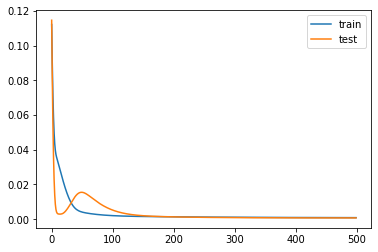

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

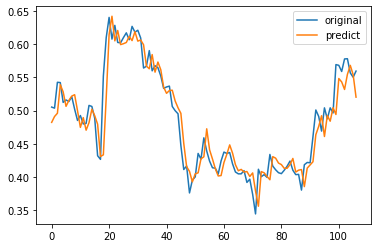

In [ ]:
pyplot.plot(test_y, label="original")
pyplot.plot(yhat, label="predict")
pyplot.legend(loc="best")

In [ ]:
# invert scaling for predict
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:
print("Price for last 5 days: ")
print(inv_yhat[-5:])

Price for last 5 days: 
[8460.189 8684.645 8817.63  8678.339 8346.058]


In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
print("Price for last 5 days: ")
print(inv_y[-5:])

Price for last 5 days: 
[8913.1   8916.301 8706.2   8641.9   8732.6  ]


In [ ]:
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 67139.320


In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 259.113


In [ ]:
mape=np.mean(np.abs((inv_y-inv_yhat)/inv_y))**100
mape

2.3512391144152085e-165

In [ ]:
units = int(int(model.layers[0].trainable_weights[0].shape[1])/4)

In [ ]:
W = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[2]

In [ ]:
#The weight of the first variable (Price) for the input gate, forget gate, cell state, and output gate.
W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

In [ ]:
W_i[0]

array([ 0.11666152,  0.1864104 ,  0.0890795 , -0.13696174,  0.3018704 ,
        0.23343024,  0.02635051,  0.08965781,  0.42472273,  0.21619132,
        0.36647484,  0.2572099 ,  0.35886914,  0.36032617, -0.15170163,
        0.0139552 , -0.02845426,  0.21553649,  0.09207667,  0.0277327 ],
      dtype=float32)

In [ ]:
W_f[0]

array([ 0.13450152, -0.14754812, -0.01277007,  0.10940856,  0.04381016,
       -0.17962864,  0.0900808 , -0.12118426, -0.04558031,  0.24276981,
        0.04848129,  0.19393346,  0.0841119 ,  0.05064425,  0.22171995,
       -0.11277604, -0.0808914 ,  0.14513844, -0.25556296,  0.1761258 ],
      dtype=float32)

In [ ]:
W_c[0]

array([-0.29560283,  0.00751943, -0.00690911, -0.09832624, -0.45414373,
       -0.18922038,  0.51855135,  0.19564338, -0.35327053, -0.17735931,
        0.18054307, -0.04255605,  0.04841319,  0.34143126,  0.08722008,
        0.38774732, -0.46069545, -0.07594061,  0.2824777 ,  0.38706833],
      dtype=float32)

In [ ]:
W_o[0]

array([ 0.25467724,  0.05476243,  0.15052445, -0.09989161,  0.35639328,
       -0.1902882 ,  0.33500767, -0.10370865, -0.07988001,  0.11509455,
        0.22573622,  0.19212611,  0.34077868,  0.40119162,  0.10016897,
        0.25333965, -0.0260212 , -0.13192627,  0.01600394, -0.12414747],
      dtype=float32)

In [ ]:
#Displays bias for input gate, forget gate, cell state, and gate output. 
#The number of biases corresponds to the number of neurons used, which is 20 so that when added up there are 80 biases in total.

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

In [ ]:
b_i

array([ 0.3445982 , -0.08327429, -0.05225599, -0.03904068,  0.10686575,
        0.22907662,  0.5380415 ,  0.06239873,  0.3531518 ,  0.03815226,
        0.05410365,  0.0229634 ,  0.02190068,  0.06641753,  0.08327544,
        0.0599434 ,  0.15495078,  0.01291186,  0.00423781,  0.09941911],
      dtype=float32)

In [ ]:
b_f

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)

In [ ]:
b_c

array([ 6.4259986e-03,  1.0170436e-02,  1.1932807e-02, -9.9126948e-03,
        1.8687303e-04,  4.2468617e-03, -4.2810976e-03, -4.2195775e-02,
        1.0516817e-02,  2.7345947e-03, -2.2129972e-02, -1.0651402e-02,
        1.3202255e-02,  6.0433554e-03, -4.0328639e-05, -1.8458912e-02,
        4.6600074e-02,  8.2053430e-03, -1.7847078e-02, -1.4458352e-02],
      dtype=float32)

In [ ]:
b_o

array([ 0.25264013, -0.073445  , -0.05719248, -0.04293421,  0.10565979,
        0.17797504,  0.5406654 ,  0.07504916,  0.27433804,  0.05283753,
        0.06150292,  0.01977607,  0.01670357,  0.07313651,  0.07111789,
        0.04862183,  0.11391768,  0.01577103,  0.00921885,  0.09276685],
      dtype=float32)